## Exercise 1)

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

import random

plt.rc("figure", dpi=100)

## Load Data

In [2]:
batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

## Helper Functions

In [3]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])

## Define Neural Network

In [4]:
# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])

## Train Network

In [5]:
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 3.96e-01
Mean Test Loss:  2.11e-01
Epoch: 10
Mean Train Loss: 1.45e-01
Mean Test Loss:  3.24e-01
Epoch: 20
Mean Train Loss: 9.54e-02
Mean Test Loss:  3.25e-01
Epoch: 30
Mean Train Loss: 8.03e-02
Mean Test Loss:  5.36e-01
Epoch: 40
Mean Train Loss: 5.61e-02
Mean Test Loss:  6.64e-01
Epoch: 50
Mean Train Loss: 3.49e-02
Mean Test Loss:  7.79e-01
Epoch: 60
Mean Train Loss: 2.76e-02
Mean Test Loss:  7.56e-01
Epoch: 70
Mean Train Loss: 2.62e-02
Mean Test Loss:  7.82e-01
Epoch: 80
Mean Train Loss: 3.22e-02
Mean Test Loss:  9.62e-01
Epoch: 90
Mean Train Loss: 1.48e-02
Mean Test Loss:  9.40e-01
Epoch: 100
Mean Train Loss: 8.91e-03
Mean Test Loss:  8.88e-01


## Plot Training Info

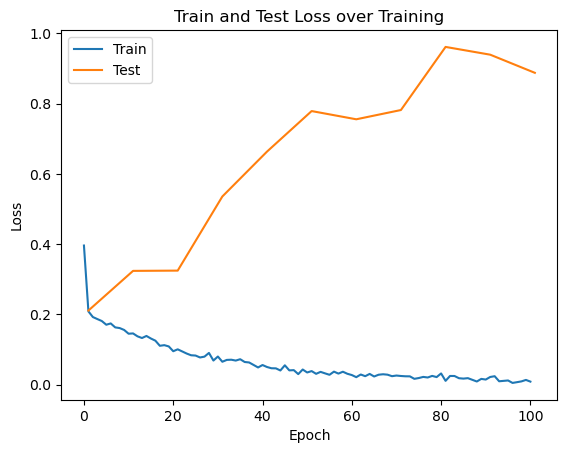

In [6]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight: bold">Comment</div>
The implementation is the same because they just ran the provided code.

# Exercise 2

## Define Dropout and Dropout Model

In [7]:
def dropout(X, p_drop=0.5):
    mask = torch.tensor(np.random.choice([0, 1], size=X.size()[1:], p=[p_drop, 1-p_drop]))
    return X * mask * (1 / (1 - p_drop))

<div style="color: green; font-weight: bold">Comment</div>

For the dropout function an if-condition should be implemented to check whether the input $p_{drop}$ lies between 0 and 1 as indicated in the sample solution.

In [8]:
# define the neural network
def dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    h = rectify(dropout(x, p_drop_input) @ w_h)
    h2 = rectify(dropout(h, p_drop_hidden) @ w_h2)
    pre_softmax = dropout(h2, p_drop_hidden) @ w_o
    return pre_softmax

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])

<div style="color: green; font-weight: bold">Comment</div>

The $dropout\_model()$ is implemented according to the task.

## Train Dropout Model

In [9]:
n_epochs = 100

train_loss = []
train_loos_without_dropout = []
test_loss = []

p_drop_input = 0.5
p_drop_hidden = 0.3

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss:                 {train_loss[-1]:.2e}")
        test_loss_this_epoch = []
        train_loss_this_epoch = []
        
        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(train_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                train_loss_this_epoch.append(float(loss))
        
        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))
        train_loos_without_dropout.append(np.mean(train_loss_this_epoch))

        print(f"Mean Train Loss without Dropout: {train_loos_without_dropout[-1]:.2e}")
        print(f"Mean Test Loss:                  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss:                 1.38e+00
Mean Train Loss without Dropout: 5.45e-01
Mean Test Loss:                  5.26e-01
Epoch: 10
Mean Train Loss:                 6.97e-01
Mean Train Loss without Dropout: 1.68e-01
Mean Test Loss:                  1.72e-01
Epoch: 20
Mean Train Loss:                 7.53e-01
Mean Train Loss without Dropout: 1.47e-01
Mean Test Loss:                  1.63e-01
Epoch: 30
Mean Train Loss:                 8.74e-01
Mean Train Loss without Dropout: 1.36e-01
Mean Test Loss:                  1.67e-01
Epoch: 40
Mean Train Loss:                 8.89e-01
Mean Train Loss without Dropout: 1.49e-01
Mean Test Loss:                  2.06e-01
Epoch: 50
Mean Train Loss:                 8.98e-01
Mean Train Loss without Dropout: 1.33e-01
Mean Test Loss:                  1.71e-01
Epoch: 60
Mean Train Loss:                 1.01e+00
Mean Train Loss without Dropout: 1.62e-01
Mean Test Loss:                  2.04e-01
Epoch: 70
Mean Train Loss:                 1.01e+

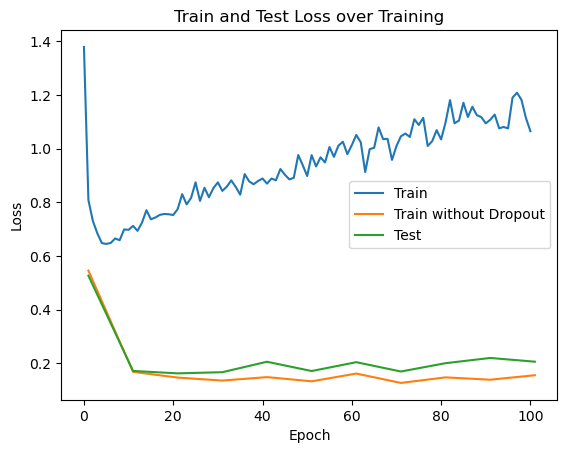

In [10]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), train_loos_without_dropout, label="Train without Dropout")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The dropout method helps with overfitting by removing the ability for the model to hyperfixate on patterns in the input. By removing or 'dropping' certain areas you prevent the model from relying on specific areas/neurons. When testing errors for the test data one should then test on the full input (wit no dropout) to get the complete image.

The test error is naturaly going to be worse when we remove information however it has the positive of being more robust as described before.

<div style="color: green; font-weight: bold">Comment</div>

Except for the definition of the dropout() function, the implementation is the same. With the addition of the calculation of the Train loss without the dropout function similar to the calculation of the Test loss.

# Exercise 3

## Define Parametric ReLU

In [11]:
def PReLU (X,a):
    return torch.max(-a * X, X) * torch.sign(X)

<div style="color: green; font-weight: bold">Comment</div>
This implementation is also correct, however using torch.where() is likely more efficient since there are fewer operations involved

## Define Model using PReLU

In [12]:
# define the neural network
def prelu_model(x, w_h, w_h2, w_o, a_h, a_h2):
    h = PReLU(x @ w_h, a_h)
    h2 = PReLU(h @ w_h2, a_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
a_h = torch.randn(size=(625, ))
a_h.requires_grad = True
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
a_h2 = torch.randn(size=(625, ))
a_h2.requires_grad = True
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o, a_h, a_h2])

<div style="color: green; font-weight: bold">Comment</div>

The prelu_model() function is missing the dropout. Additionally, instead of creating a tensor filled with zeros like the solution, this code initializes a tensor filled with random values drawn from a standard normal distribution. This approach is also correct. The solution initializes $a$ with 0 and Kaiming He et al. suggests using initial values of 0.25.

## Train PReLU Model

In [13]:
n_epochs = 100

train_loss = []
test_loss = []

p_drop_input = 0.5
p_drop_hidden = 0.3

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = prelu_model(x, w_h, w_h2, w_o, a_h, a_h2)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []
        
        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = prelu_model(x, w_h, w_h2, w_o, a_h, a_h2)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))
        train_loos_without_dropout.append(np.mean(train_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 7.71e-01
Mean Test Loss:  2.99e-01
Epoch: 10
Mean Train Loss: 1.66e-01
Mean Test Loss:  2.65e-01
Epoch: 20
Mean Train Loss: 1.18e-01
Mean Test Loss:  4.17e-01
Epoch: 30
Mean Train Loss: 1.03e-01
Mean Test Loss:  4.96e-01
Epoch: 40
Mean Train Loss: 8.15e-02
Mean Test Loss:  5.13e-01
Epoch: 50
Mean Train Loss: 6.63e-02
Mean Test Loss:  7.67e-01
Epoch: 60
Mean Train Loss: 5.42e-02
Mean Test Loss:  6.87e-01
Epoch: 70
Mean Train Loss: 4.84e-02
Mean Test Loss:  6.29e-01
Epoch: 80
Mean Train Loss: 4.96e-02
Mean Test Loss:  8.33e-01
Epoch: 90
Mean Train Loss: 4.89e-02
Mean Test Loss:  8.74e-01
Epoch: 100
Mean Train Loss: 4.04e-02
Mean Test Loss:  7.22e-01


<div style="color: green; font-weight: bold">Comment</div>

The implementation of the train loop is essentially the same.

## Plot Training Info

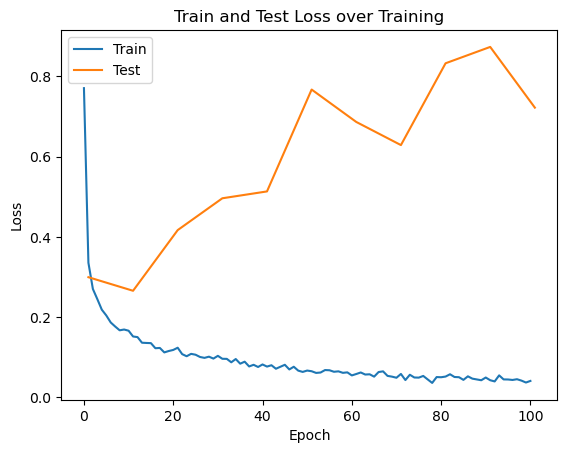

In [14]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

We see that the error rate is better with PReLU compared to ReLU. This is because PReLU allows the network to adapt the slope of the activation function for negative inputs. This should improve learning, especially in networks where the ability to learn more nuanced activation patterns can be beneficial.

<div style="color: green; font-weight: bold">Comment</div>
Except for missing the dropout functionality, this solution is correct.

# Exercise 4)

## Part 4.1 

### Define Model

In [15]:
def convolution_layer(previous_layer, weight_vector, k_x, k_y, p_drop_input):
    conv_layer = rectify(conv2d(previous_layer, weight_vector))
    subsampling_layer = max_pool2d(conv_layer, (2, 2))
    return dropout(subsampling_layer, p_drop_input)

# define the neural network
def convolution_model(x, c1_weight_vector, c2_weight_vector, c3_weight_vector, p_drop_input, w_h2, w_o):
    c1 = convolution_layer(x, c1_weight_vector, 5, 5, p_drop_input)
    c2 = convolution_layer(c1, c2_weight_vector, 5, 5, p_drop_input)
    c3 = convolution_layer(c2, c3_weight_vector, 3, 3, p_drop_input)

    c3 = c3.reshape(-1, 128)
    
    h2 = rectify(c3 @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights

c1_weight_vector = init_weights((32, 1, 5, 5))
c2_weight_vector = init_weights((64, 32, 5, 5))
c3_weight_vector = init_weights((128, 64, 3, 3))
    
# hidden layer with 625 neurons
w_h2 = init_weights((128, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[c1_weight_vector, c2_weight_vector, c3_weight_vector, w_h2, w_o])

<div style="color: green; font-weight: bold">Comment</div>

- This solution only uses one $p_{drop}$ value for all layers.
- They also pass the Kernel size as parameters to the convolution_layer where they aren't needed since they are included in the "weights".
- At the beginning of convolution_model they should call dropout on the input according to the task.
- They used .reshape() instead of torch.reshape() but accomplish the same result.


### Train Model

In [16]:
n_epochs = 100

p_drop_input = 0.5

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(-1, 1, 28, 28)
        # feed input through model
        noise_py_x = convolution_model(x, c1_weight_vector, c2_weight_vector, c3_weight_vector, p_drop_input, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(-1, 1, 28, 28)
                noise_py_x = convolution_model(x, c1_weight_vector, c2_weight_vector, c3_weight_vector, p_drop_input, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 8.12e+00
Mean Test Loss:  1.71e+00
Epoch: 10
Mean Train Loss: 3.35e-01
Mean Test Loss:  3.11e-01
Epoch: 20
Mean Train Loss: 3.72e-01
Mean Test Loss:  3.49e-01
Epoch: 30
Mean Train Loss: 3.99e-01
Mean Test Loss:  4.54e-01
Epoch: 40
Mean Train Loss: 4.29e-01
Mean Test Loss:  3.57e-01
Epoch: 50
Mean Train Loss: 4.83e-01
Mean Test Loss:  4.26e-01
Epoch: 60
Mean Train Loss: 5.10e-01
Mean Test Loss:  5.03e-01
Epoch: 70
Mean Train Loss: 5.51e-01
Mean Test Loss:  5.30e-01
Epoch: 80
Mean Train Loss: 5.80e-01
Mean Test Loss:  5.87e-01
Epoch: 90
Mean Train Loss: 5.97e-01
Mean Test Loss:  5.40e-01
Epoch: 100
Mean Train Loss: 6.63e-01
Mean Test Loss:  6.30e-01


<div style="color: green; font-weight: bold">Comment</div>

The implementation of the train loop is correct. There is no plot of an image from the test set with it's convolution with 3 filters and the corresponding filters.

### Plot Training Info

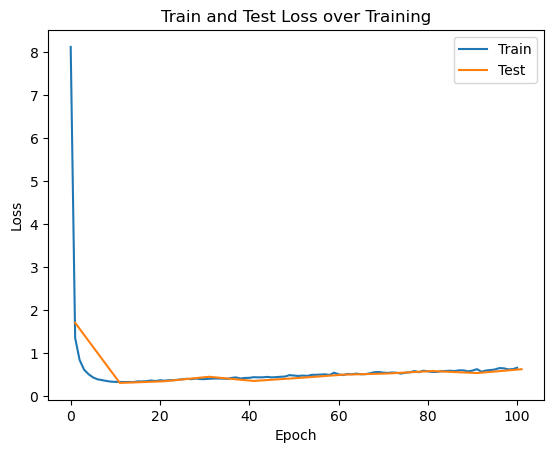

In [17]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Part 4.2
We opted to implement the random linear shift, we determine a random shift for each individual batch.

### Modified Training

In [18]:
n_epochs = 100

p_drop_input = 0.5

train_loss = []
test_loss = []

shift_right = np.zeros((28, 28))
shift_down = np.zeros((28, 28))

for i in range(28):
    shift_right[i, (i + 1) % 28] = 1
    shift_down[(i + 1) % 28, i] = 1
shift_right = torch.tensor(shift_right).float()
shift_down = torch.tensor(shift_down).float()

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        dx = random.randint(0, 27)
        dy = random.randint(0, 27)
        shift = shift_right ** dx + shift_down ** dy
        
        x, y = batch

        # our model requires flattened input
        x = x.reshape(-1, 1, 28, 28) @ shift
        # feed input through model
        noise_py_x = convolution_model(x, c1_weight_vector, c2_weight_vector, c3_weight_vector, p_drop_input, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(-1, 1, 28, 28)
                noise_py_x = convolution_model(x, c1_weight_vector, c2_weight_vector, c3_weight_vector, p_drop_input, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 4.08e+00
Mean Test Loss:  2.43e+00
Epoch: 10
Mean Train Loss: 2.52e+00
Mean Test Loss:  1.81e+00
Epoch: 20
Mean Train Loss: 2.34e+00
Mean Test Loss:  2.12e+00
Epoch: 30
Mean Train Loss: 2.03e+00
Mean Test Loss:  2.40e+00
Epoch: 40
Mean Train Loss: 1.99e+00
Mean Test Loss:  4.43e+00
Epoch: 50
Mean Train Loss: 2.46e+00
Mean Test Loss:  3.23e+00
Epoch: 60
Mean Train Loss: 2.43e+00
Mean Test Loss:  2.34e+00
Epoch: 70
Mean Train Loss: 3.41e+00
Mean Test Loss:  3.80e+00
Epoch: 80
Mean Train Loss: 2.16e+00
Mean Test Loss:  3.53e+00
Epoch: 90
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.53e+00
Epoch: 100
Mean Train Loss: 3.45e+00
Mean Test Loss:  2.59e+00


<div style="color: green; font-weight: bold">Comment</div>

They effectively apply a random linear shift to each picture which should introduce robustness to the training by forcing the network to learn more general patterns to differentiate the numbers, potentially reducing overfitting.

### Plot Training Info

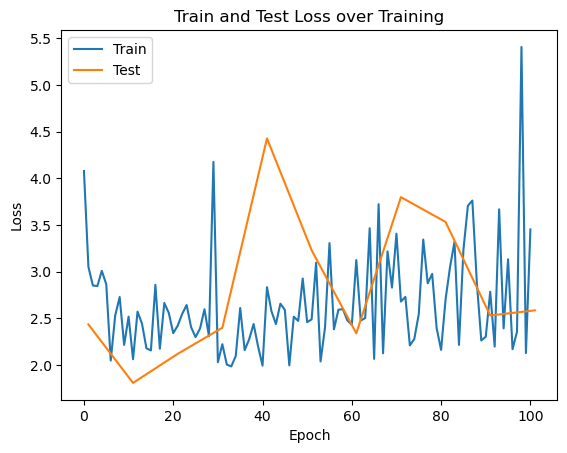

In [19]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Network Sketch
![](ex4-sketch.png)

<div style="color: green; font-weight: bold">Comment</div>

Their sketch effectively visualizes the concept of the network and their outputsizes and channelsizes were all correct.

When comparing the error rates we see that the mean test loss and training loss are worse than wihout the linear shifts. In theory the linear shift will reduce overfitting as it will force the network to focus on the general iamge rather than a specific part. It is natural that the test loss is worse. By reducing overfitting it will also make the fit worse (It's a balancing act). Maybe with an even larger data-set we could see the improvements on test-loss.